In [159]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
from sklearn.model_selection import train_test_split



In [160]:
#load the image arrays 

blends = np.load("C:\\Datasets\\blends.npy")
components = np.load("C:\\Datasets\\components.npy")

In [161]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(comp1[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(comp2[i], ax[2, i], f'comp2 {idx[i]}')
        showimg(output_img1[i], ax[3, i], f'output1\n{encoding}')
        showimg(output_img2[i], ax[4, i], f'output2\n{encoding}')
        showimg(output_img1[i] + output_img2[i], ax[5, i], f'outblend\n{encoding}')
    return idx



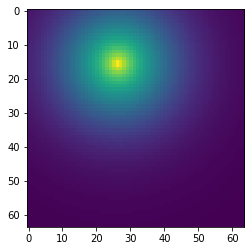

In [162]:
height,width=64,64
n_gals = len(blends)

#normalise 
blends /= 255
components /= 255

#Seperating into test and train datasets at 0.8, 0.2 respectively
train_blends, test_blends, train_components, test_components = train_test_split(blends, components, test_size = 0.2, shuffle = False)

#I tried to reshape components however I ran into problems using the train_test_split when 
#components had been reshaped before it was called

train_num = train_blends.shape[0] 
test_num = test_blends.shape[0] 

train_blends = train_blends.reshape(train_num, height, width, 1).astype('float32')
#train_components is 800, 2, 64, 64 
#print(train_components.shape)
plt.imshow(train_components[20,1])
#train_components = train_components.reshape(2, train_num, height, width, 1).astype('float32')

In [163]:
batch_size = 100
#plt.imshow(train_components[0,19])

In [164]:
# PREVIOUS LATENT DIMENSIONS WAS ONLY 2!
# WAY TOO SMALL TO ENCODE INFO HENCE POOR RESULTS
latent_dimensions = 32

In [165]:
train_blends.shape, train_components.shape

((800, 64, 64, 1), (800, 2, 64, 64))

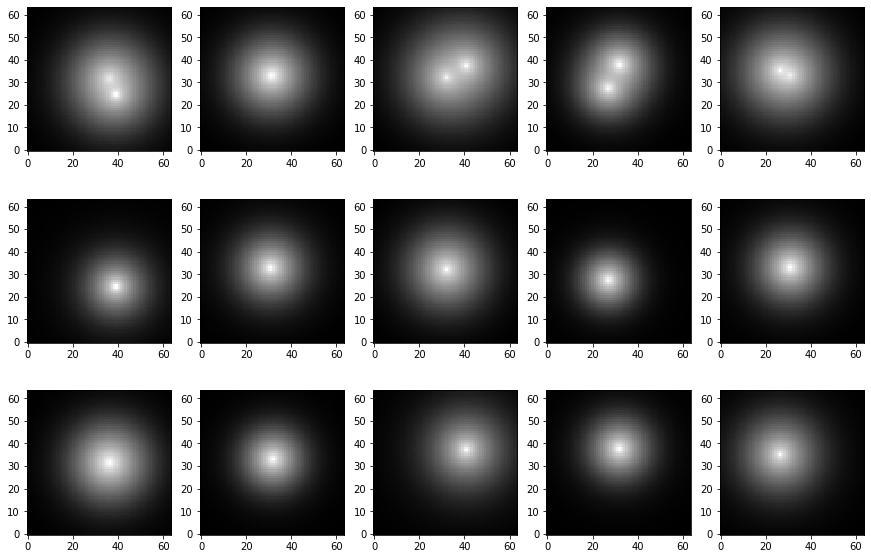

In [166]:
#Check the images print right 
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], cmap='gray', origin='lower', interpolation='nearest')
    for j in range(2):
        ax[j + 1, i].imshow(train_components[i, j], cmap='gray', origin='lower', interpolation='nearest') 

In [167]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    return x

In [168]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [169]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [170]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [171]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [172]:
encode=Model(input_blend,z)
encode.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 32, 32)   320         ['input_21[0][0]']               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 32)   9248        ['conv2d_20[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_21[0][0]']              
                                                                                           

In [173]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 1024)         33792       ['input_22[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 1024)         33792       ['input_22[0][0]']               
                                                                                                  
 reshape_10 (Reshape)           (None, 4, 4, 64)     0           ['dense_22[0][0]']               
                                                                                           

In [174]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [175]:
vae.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_15 (Functional)          (None, 32)           130592      ['input_21[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                           

In [176]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

train_components1, train_components2 = np.split(train_components,2,axis=1)
train_components1 = train_components1.reshape(train_num, height, width, 1).astype('float32')
train_components2 = train_components2.reshape(train_num, height, width, 1).astype('float32')

print(train_components1.shape)

together = [train_blends, train_components1, train_components2]
vae.compile(optimizer=Adam())

(800, 64, 64, 1)


In [ ]:
history=vae.fit(together, verbose=1, epochs=3, batch_size=batch_size)

Epoch 1/3
8/8 [==============================] - 14s 1s/step - loss: 0.0229 - mse_loss: 0.0229 - kl_loss: 7.0289e-06
Epoch 2/3
8/8 [==============================] - 8s 1s/step - loss: 0.0069 - mse_loss: 0.0068 - kl_loss: 2.3671e-05
Epoch 3/3
6/8 [=====================>........] - ETA: 2s - loss: 0.0066 - mse_loss: 0.0066 - kl_loss: 8.1877e-06

[  8 510 175 735 242]


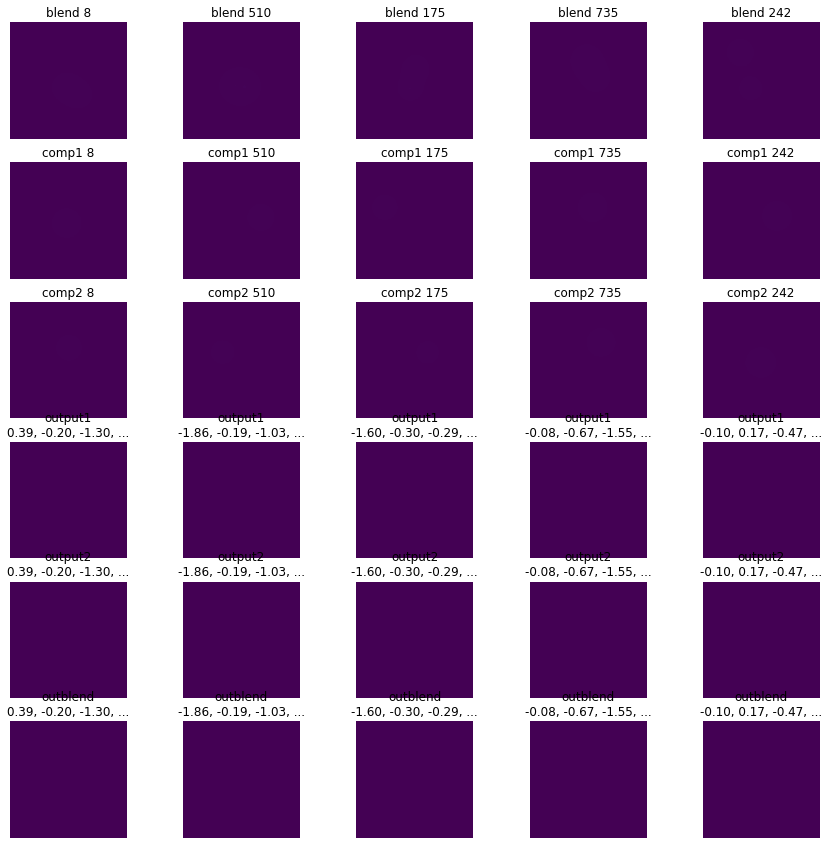

In [52]:
n=5
chosen=summary_plot(n,together,decode)